# Problem B

## Download data

In [0]:
!wget -nc 140.114.77.221:8000/ccpd6000.zip
!unzip -nq ccpd6000.zip
!ls -alh
!sha256sum ccpd6000.zip

--2019-12-12 15:25:20--  http://140.114.77.221:8000/ccpd6000.zip
Connecting to 140.114.77.221:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332013713 (317M) [application/zip]
Saving to: ‘ccpd6000.zip’

ccpd6000.zip        100%[===================>] 316.63M  2.49MB/s    in 2m 17s  

2019-12-12 15:27:38 (2.32 MB/s) - ‘ccpd6000.zip’ saved [332013713/332013713]

total 317M
drwxr-xr-x 1 root root 4.0K Dec 12 15:27 .
drwxr-xr-x 1 root root 4.0K Dec 12 15:24 ..
drwxr-xr-x 4 root root 4.0K Nov 19 11:35 ccpd6000
-rw-r--r-- 1 root root 317M Nov 19 11:44 ccpd6000.zip
drwxr-xr-x 1 root root 4.0K Dec  6 16:53 .config
drwxr-xr-x 1 root root 4.0K Dec  6 16:53 sample_data
977d7124a53e565c3f2b371a871ee04ebbe572f07deb0b38c5548ddaae0cb2c9  ccpd6000.zip


## Init and Utility

In [0]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display
from skimage import util

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [0]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

## Training Data

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


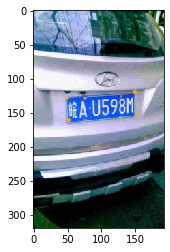

In [0]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.tsfrm = transforms.Compose([
            transforms.Resize(IMG_SIZE[::-1]),
            transforms.ToTensor()
        ])

    def __len__(self):
        '''Return the number of samples'''
        # raise NotImplementedError()
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        # raise NotImplementedError()
        ann = self.anns[idx]

        raw_img = Image.open(self.img_dir / ann['name'])
        # image = tf.resize(raw_img, IMG_SIZE[::-1])
        # img_arr = util.img_as_float32(image).transpose((2, 0, 1))
        # img = torch.from_numpy(img_arr)
        img = self.tsfrm(raw_img)

        w, h = raw_img.size
        kpt_arr = np.float32([ ann[col] / w if 'x' in col else ann[col] / h
                            for col in FIELDS ])
        kpt = torch.from_numpy(kpt_arr)

        return img, kpt

# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

## Network

In [0]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)'''
        super().__init__() # necessary
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((4, 4)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
        )
        self.regression = nn.Sequential(
            nn.Flatten(),
            nn.Linear(480, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.Sigmoid()
        )

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and 
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        # raise NotImplementedError()
        result = self.features(img_b)
        kpt_b = self.regression(result)

        return kpt_b

# Do some checking
loader = DataLoader(data, batch_size=10) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([10, 3, 320, 192])
torch.Size([10, 8])
tensor(0.1254, device='cuda:0', grad_fn=<L1LossBackward>)


## Training

Epoch 000:
train loss: 0.0024748550491494824
valid loss: 0.0007163376513441715
Epoch 001:
train loss: 0.0005860122152929156
valid loss: 0.0005170250745626012
Epoch 002:
train loss: 0.00042778976276167666
valid loss: 0.0004127851260515551
Epoch 003:
train loss: 0.00034371995558709993
valid loss: 0.0004044667490234133
Epoch 004:
train loss: 0.0002497379307593898
valid loss: 0.00023335782728584794
Epoch 005:
train loss: 0.0002697514605946102
valid loss: 0.00030287888075690715
Epoch 006:
train loss: 0.00023500117489068847
valid loss: 0.0004117782819472874
Epoch 007:
train loss: 0.00021169289996881465
valid loss: 0.0002046528668870451
Epoch 008:
train loss: 0.00016748936138052766
valid loss: 0.00022388162033166737
Epoch 009:
train loss: 0.00016226314880138186
valid loss: 0.00018951195355233115


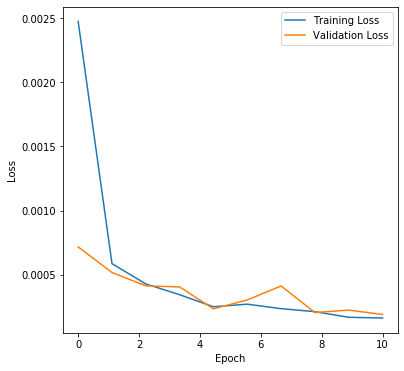

In [12]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, 10, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 10, shuffle=False, num_workers=4)
        self.visul_loader = DataLoader(self.visul_set, 10, shuffle=False)

        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = Net().to(self.device)
        # self.criterion = nn.L1Loss()
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.max_epoch = 10

    def run(self):
        metrics = {'train_loss': [], 'valid_loss': []}

        for self.epoch in range(self.max_epoch): # 5 epochs
            train_loss = self.train() # train 1 epoch
            valid_loss = self.valid() # valid 1 epoch
            self.visul()              # visualization

            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)

        # Save the parameters(weights) of the model to disk
        # raise NotImplementedError()
        torch.save(self.model.state_dict(), 'model.tar')

        # Plot the loss curve against epoch
        # raise NotImplementedError()

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

        x = np.linspace(0, self.max_epoch, self.max_epoch)
        ax.plot(x, metrics['train_loss'], label='Training Loss')
        ax.plot(x, metrics['valid_loss'], label='Validation Loss')
        
        ax.legend()
        plt.savefig(self.log_dir / 'metrics.png')

        plt.show()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        # raise NotImplementedError()
        running_loss = []

        self.model.train()

        for xb, yb in iter(self.train_loader):
            xb = xb.to(self.device)
            yb = yb.to(self.device)

            pred = self.model(xb)
            loss = self.criterion(pred, yb)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            running_loss.append(loss.item())

        return np.mean(running_loss)


    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        # raise NotImplementedError()
        running_loss = []

        self.model.eval()

        for xb, yb in iter(self.valid_loader):
            xb = xb.to(self.device)
            yb = yb.to(self.device)

            pred = self.model(xb)
            loss = self.criterion(pred, yb)
            running_loss.append(loss.item())

        return np.mean(running_loss)

    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='red')
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
Trainer(log_dir).run()

## Testing

In [0]:
# Do testing
# raise NotImplementedError()
class TestData(Dataset):
    def __init__(self, img_dir):
        super().__init__()
        self.img_dir = Path(img_dir)
        self.tsfrm = transforms.Compose([transforms.Resize(IMG_SIZE[::-1]),
                                         transforms.ToTensor()])

    def __len__(self):
        return 3000

    def __getitem__(self, idx):
        raw_img = Image.open(self.img_dir / f'{idx:04d}.jpg')
        img = self.tsfrm(raw_img)

        return img, raw_img.size

test_data = TestData(ROOT_DIR / 'test_images')
test_loader = DataLoader(test_data, batch_size=1)
device = 'cuda'

test_model = Net().to(device)
test_model.load_state_dict(torch.load('model.tar'))
test_model.eval()

pred_list = []

for idx, (img, dim) in enumerate(test_loader):
    pred = test_model(img.to(device)).to('cpu')

    rescale = torch.tensor(dim).repeat(4)
    kpts = (pred * rescale).round().reshape(-1).tolist()
    name = [ f'{idx:04d}.jpg' ]

    pred_list.append(name + kpts)

df = pd.DataFrame(pred_list, columns=['name']+FIELDS)
df.to_csv('./ccpd6000/test.csv')

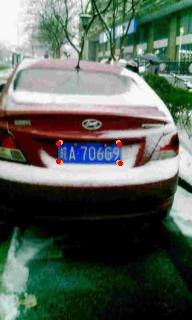

In [16]:
display.Image(str(log_dir / '004' / '000.jpg')) # A visualization of training data in epoch 4

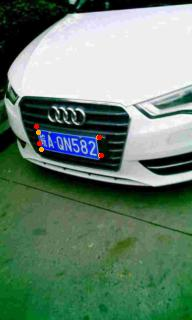

In [17]:
display.Image(str(log_dir / '004' / '025.jpg')) # A visualization of validation data in epoch 4

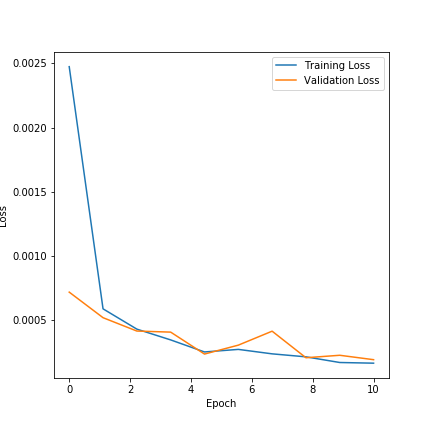

In [14]:
display.Image(str(log_dir / 'metrics.png')) # Loss

In [15]:
!curl -F "file=@./ccpd6000/test.csv" -X POST 140.114.76.113:5000/cs6550 -i

HTTP/1.1 100 Continue

HTTP/1.0 200 OK
Content-Type: application/json
Content-Length: 15
Server: Werkzeug/0.16.0 Python/3.7.5
Date: Thu, 12 Dec 2019 15:43:19 GMT

{"rmse":17.08}
